In [3]:
# 1.1 Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

# Date/Time handling
from datetime import datetime, timedelta

# Serialization
import pickle
import joblib


In [4]:
df=pd.read_csv("SparePartsInventory!.csv")


In [5]:
part_summary=pd.read_csv("part_summary.csv")

In [6]:
pd.set_option('display.max_columns',None)

In [7]:
df

,part_id,part_type,location_id,region,d,daily_demand_units,date,year_week,day_name,day_num,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_event,is_weekend,snap_flag,week_of_month,season,day_of_year,is_payday,is_working_Day,event_in_3days,event_in_7days,is_month_start,is_month_end,unit_cost,revenue,part_class,id,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,volatility_ratio_30,volatility_class,log_demand,ADI,CV_squared,intermittency_pct,demand_type,replenishment_strategy,volume_class,ABC_Class,XYZ_Class,ABC_XYZ,ABC_numeric,XYZ_numeric,volatility_numeric
0,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_1,2,2011-01-29,2011_W04,Saturday,1,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,29,0,0,0,0,0,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110129_Dd_1,2.000000,NaN,2.000000,NaN,NaN,Unknown,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,NaN
1,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_2,3,2011-01-30,2011_W04,Sunday,2,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,30,1,0,0,1,0,0,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110130_Dd_2,2.500000,0.707107,2.500000,0.707107,0.282843,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
2,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_3,3,2011-01-31,2011_W05,Monday,3,1,2011,No Event,No Event,0,0,0,0,0,0,5,Early-Year Stock Reset,31,1,1,0,0,0,1,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110131_Dd_3,2.666667,0.577350,2.666667,0.577350,0.216506,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
3,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_4,2,2011-02-01,2011_W05,Tuesday,4,2,2011,No Event,No Event,1,1,0,0,0,1,1,Spring Promotions,32,1,1,0,0,1,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110201_Dd_4,2.500000,0.577350,2.500000,0.577350,0.230940,Highly Stable,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
4,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_5,0,2011-02-02,2011_W05,Wednesday,5,2,2011,No Event,No Event,1,0,1,0,0,1,1,Spring Promotions,33,0,1,0,0,0,0,2.94,0.00,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110202_Dd_5,2.000000,1.224745,2.000000,1.224745,0.612372,Highly Stable,0.000000,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441738,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1909,0,2016-04-20,2016_W16,Wednesday,5,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,111,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160420_Dd_1909,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441739,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1910,0,2016-04-21,2016_W16,Thursday,6,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,112,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160421_Dd_1910,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441740,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1911,0,2016-04-22,2016_W16,Friday,7,4,2016,No Event,No Event,0,0,0,0,0,0,4,NaN,113,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160422_Dd_1911,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441741,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1912,0,2016-04-23,2016_W16,Saturday,1,4,2016,No Event,No Event,0,0,0,0,1,0,4,NaN,114,0,0,0,1,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160423_Dd_1912,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C

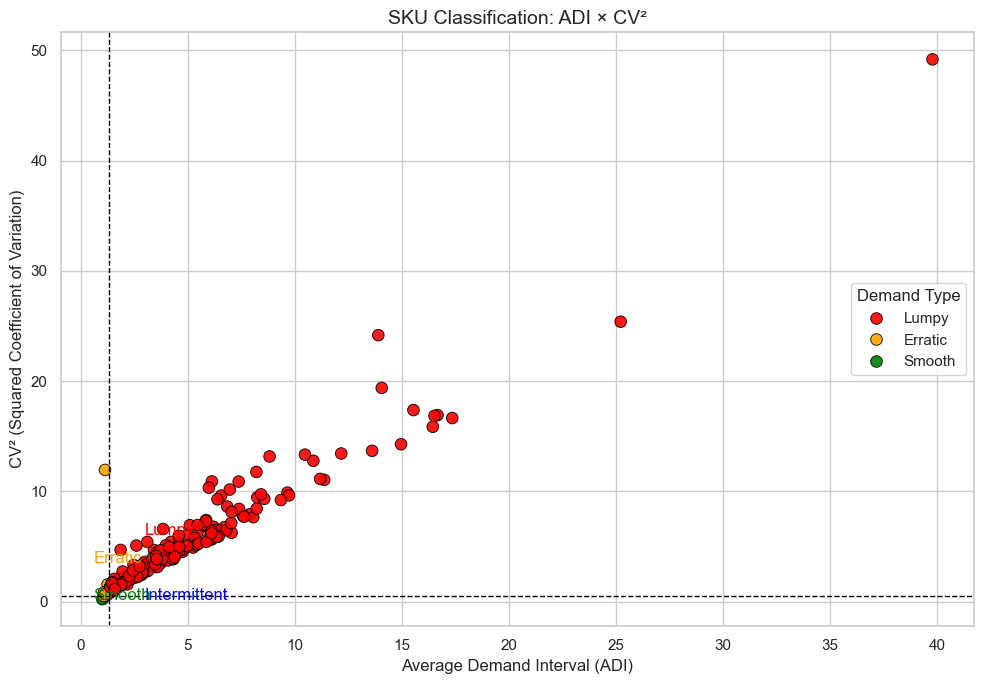

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(
    data=part_summary,
    x="ADI",
    y="CV_squared",
    hue="demand_type",
    palette={
        "Smooth": "green",
        "Intermittent": "blue",
        "Erratic": "orange",
        "Lumpy": "red"
    },
    alpha=0.9,
    s=70,
    edgecolor='black'
)

# Threshold lines
plt.axhline(y=0.49, color='black', linestyle='--', linewidth=1)
plt.axvline(x=1.32, color='black', linestyle='--', linewidth=1)

# Zone annotations
plt.text(0.6, 0.1, "Smooth", fontsize=12, color='green')
plt.text(0.6, 3.5, "Erratic", fontsize=12, color='orange')
plt.text(3, 0.1, "Intermittent", fontsize=12, color='blue')
plt.text(3, 6, "Lumpy", fontsize=12, color='red')

# Labels
plt.title("SKU Classification: ADI × CV²", fontsize=14)
plt.xlabel("Average Demand Interval (ADI)", fontsize=12)
plt.ylabel("CV² (Squared Coefficient of Variation)", fontsize=12)
plt.legend(title="Demand Type")
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd

def croston_forecast(demand, alpha=0.1):
    demand = np.array(demand)
    n = len(demand)
    z = 0  # demand size
    p = 0  # interval
    q = 1  # counter
    first = True

    forecast = np.zeros(n)

    for t in range(n):
        if demand[t] > 0:
            if first:
                z = demand[t]
                p = q
                first = False
            else:
                z = alpha * demand[t] + (1 - alpha) * z
                p = alpha * q + (1 - alpha) * p
            q = 1
        else:
            q += 1

        forecast[t] = z / p if p > 0 else 0

    return forecast


In [10]:
def sba_forecast(demand, alpha=0.1):
    croston_series = croston_forecast(demand, alpha)
    return 0.95 * croston_series


In [11]:
def tsb_forecast(demand, alpha=0.1, beta=0.1):
    demand = np.array(demand)
    n = len(demand)
    z = 0  # demand size
    p = 0  # probability of demand
    first = True

    forecast = np.zeros(n)

    for t in range(n):
        if demand[t] > 0:
            if first:
                z = demand[t]
                p = 1
                first = False
            else:
                z = alpha * demand[t] + (1 - alpha) * z
                p = beta + (1 - beta) * p
        else:
            p = (1 - beta) * p

        forecast[t] = z * p

    return forecast


In [12]:
from prophet import Prophet
import pandas as pd

def prophet_forecast(df_sku):
    # Prepare data for Prophet
    df_prophet = df_sku[['date', 'daily_demand_units']].rename(columns={
        'date': 'ds',
        'daily_demand_units': 'y'
    })
    
    # Drop missing values
    df_prophet = df_prophet.dropna()

    if len(df_prophet) < 30:
        return [df_prophet['y'].mean()] * len(df_prophet)

    # Fit Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=0, freq='D')  # match historical size only
    forecast = model.predict(future)
    
    return forecast['yhat'].values



In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def ets_forecast(demand, seasonal_periods=7):
    try:
        model = ExponentialSmoothing(demand, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        model_fit = model.fit(optimized=True)
        return model_fit.fittedvalues.tolist()
    except:
        return [np.mean(demand)] * len(demand)

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_forecast(df_sku):
    # Ensure the data is sorted by time
    df_sku = df_sku.sort_values("date")

    # Set the index to date
    df_sku.set_index("date", inplace=True)

    # If too few observations or all zero/same, fallback to mean
    if len(df_sku) < 20 or df_sku["daily_demand_units"].nunique() < 2:
        return [df_sku["daily_demand_units"].mean()] * len(df_sku)

    # Fit SARIMAX model (simple seasonal version with daily frequency)
    try:
        model = SARIMAX(
            df_sku["daily_demand_units"],
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),  # weekly seasonality
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        forecast = results.predict(start=0, end=len(df_sku)-1)
        return forecast.tolist()
    
    except Exception as e:
        print(f"Fallback for SKU due to SARIMAX failure: {e}")
        return [df_sku["daily_demand_units"].mean()] * len(df_sku)



In [15]:
def combination_forecast(*forecast_lists):
    combined = np.mean(np.array(forecast_lists), axis=0)
    return combined.tolist()

In [16]:
import scipy.stats as stats

def fit_best_distribution(demand_series):
    distributions = {
        "Poisson": stats.poisson,
        "Exponential": stats.expon,
        "Gamma": stats.gamma,
        "Log-Normal": stats.lognorm,
        "Normal": stats.norm,
        "Negative Binomial": stats.nbinom
    }

    best_fit = None
    best_ks_stat = float('inf')

    for dist_name, dist in distributions.items():
        try:
            params = dist.fit(demand_series)
            D, _ = stats.kstest(demand_series, dist_name.lower(), args=params)
            if D < best_ks_stat:
                best_ks_stat = D
                best_fit = dist_name
        except Exception:
            continue

    return best_fit


In [17]:
distribution_map = (
    df.groupby("part_id")["daily_demand_units"]
    .apply(lambda x: fit_best_distribution(x[x > 0]))  
)

part_summary = part_summary.merge(distribution_map, on="part_id", how="left")


In [18]:
def assign_forecast_model(row):
    demand_type = row['demand_type']
    abc = row['ABC_Class']
    xyz = row['XYZ_Class']
    volatility = row['volatility_class']

    # 1. High-volatility + high-importance SKUs → Prophet (probabilistic, interpretable)
    if volatility == "Highly Volatile" and abc in ["A", "B"]:
        return "Prophet"

    # 2. Lumpy and highly unpredictable SKUs → TSB (best for zero-heavy series)
    if demand_type == "Lumpy" and xyz == "Z":
        return "TSB"

    # 3. Intermittent but moderately regular → Croston (event spacing driven)
    if demand_type == "Intermittent" and xyz == "Y":
        return "Croston"

    # 4. Erratic + high-value SKUs (event-driven & promotion-sensitive) → SARIMAX
    if demand_type == "Erratic" and abc == "A":
        return "SARIMAX"

    # 5. Smooth & seasonal → ETS (classic trend + seasonality)
    if demand_type == "Smooth":
        return "ETS"

    # 6. Fallback: Combine multiple methods (TSB + Croston + Prophet)
    return "Combination"


In [19]:
part_summary['assigned_model'] = part_summary.apply(assign_forecast_model, axis=1)

In [20]:
part_summary['assigned_model'].value_counts()

assigned_model
TSB            233
Prophet         26
SARIMAX         16
Combination     12
ETS              3
Name: count, dtype: int64

## Forecast Model SKU Segmentation

In [21]:
# Step 1: Create lookup dictionaries per model
skus_tsb = part_summary[part_summary['assigned_model'] == 'TSB']['part_id'].unique()
skus_croston = part_summary[part_summary['assigned_model'] == 'Croston']['part_id'].unique()
skus_prophet = part_summary[part_summary['assigned_model'] == 'Prophet']['part_id'].unique()
skus_sarimax = part_summary[part_summary['assigned_model'] == 'SARIMAX']['part_id'].unique()
skus_ets = part_summary[part_summary['assigned_model'] == 'ETS']['part_id'].unique()
skus_combination = part_summary[part_summary['assigned_model'] == 'Combination']['part_id'].unique()


In [22]:
# Step 2: Subset the main dataframe for each group
df_tsb = df[df['part_id'].isin(skus_tsb)]
df_croston = df[df['part_id'].isin(skus_croston)]
df_prophet = df[df['part_id'].isin(skus_prophet)]
df_sarimax = df[df['part_id'].isin(skus_sarimax)]
df_ets = df[df['part_id'].isin(skus_ets)]
df_combination = df[df['part_id'].isin(skus_combination)]


## TSB forecast

In [23]:
forecast_results = []

# TSB
for sku in df_tsb['part_id'].unique():
    sku_df = df_tsb[df_tsb['part_id'] == sku].sort_values("date")
    series = sku_df['daily_demand_units'].values
    forecast = tsb_forecast(series)
    forecast_results.extend(zip(
        [sku] * len(forecast),
        sku_df['date'],
        sku_df['id'],  # <-- include id
        forecast,
        ['TSB'] * len(forecast)
    ))

# Croston
for sku in df_croston['part_id'].unique():
    sku_df = df_croston[df_croston['part_id'] == sku].sort_values("date")
    series = sku_df['daily_demand_units'].values
    forecast = croston_forecast(series)
    forecast_results.extend(zip(
        [sku] * len(forecast),
        sku_df['date'],
        sku_df['id'],
        forecast,
        ['Croston'] * len(forecast)
    ))

# Prophet
for sku in df_prophet['part_id'].unique():
    sku_df = df_prophet[df_prophet['part_id'] == sku].sort_values("date")
    forecast = prophet_forecast(sku_df)  
    forecast_results.extend(zip(
        [sku] * len(forecast),
        sku_df['date'],
        sku_df['id'],
        forecast,
        ['Prophet'] * len(forecast)
    ))
# SARIMAX
for sku in df_sarimax['part_id'].unique():
    sku_df = df_sarimax[df_sarimax['part_id'] == sku].sort_values("date")
    forecast = sarimax_forecast(sku_df)
    forecast_results.extend(zip(
        [sku] * len(forecast),
        sku_df['date'],
        sku_df['id'],
        forecast,
        ['SARIMAX'] * len(forecast)
    ))

# ETS
for sku in df_ets['part_id'].unique():
    sku_df = df_ets[df_ets['part_id'] == sku].sort_values("date")
    series = sku_df['daily_demand_units'].values
    forecast = ets_forecast(series)
    forecast_results.extend(zip(
        [sku] * len(forecast),
        sku_df['date'],
        sku_df['id'],
        forecast,
        ['ETS'] * len(forecast)
    ))

# Combination (TSB + Croston + Prophet)
for sku in df_combination['part_id'].unique():
    sku_df = df_combination[df_combination['part_id'] == sku].sort_values("date")
    series = sku_df['daily_demand_units'].values
    f1 = tsb_forecast(series)
    f2 = croston_forecast(series)
    f3 = prophet_forecast(sku_df)
    combined = combination_forecast(f1, f2, f3)
    forecast_results.extend(zip(
        [sku] * len(combined),
        sku_df['date'],
        sku_df['id'],
        combined,
        ['Combination'] * len(combined)
    ))


22:53:49 - cmdstanpy - INFO - Chain [1] start processing
22:53:49 - cmdstanpy - INFO - Chain [1] done processing
22:53:49 - cmdstanpy - INFO - Chain [1] start processing
22:53:49 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1]

In [24]:
forecast_df = pd.DataFrame(forecast_results, columns=["part_id", "date", "id", "forecast", "model_used"])


In [25]:
forecast_df['model_used'].value_counts()

model_used
TSB            349781
Prophet         41919
SARIMAX         28605
Combination     15704
ETS              3863
Name: count, dtype: int64

  
## Calculates a comprehensive suite of the best-researched forecast accuracy metrics tailored for intermittent demand.

    This function removes less accurate metrics like MAPE and uses the standard
    definitions for MASE and other advanced metrics.

    Args:
        y_actual (np.ndarray): The array of actual observed values (the test set).
        y_forecast (np.ndarray): The array of forecasted values.
        y_train (np.ndarray): The array of historical training data, needed for standard MASE scaling.
        unit_cost (float): The cost of one unit of the SKU, for cost-based metrics.
        holding_cost_rate (float): The annual cost to hold one dollar of inventory (e.g., 0.25 for 25%).
        stockout_cost_multiplier (float): A multiplier for unit_cost to estimate the per-unit cost of a stockout.

    Returns:
        dict: A dictionary containing the most relevant and robust metrics.
    

In [34]:
df

,part_id,part_type,location_id,region,d,daily_demand_units,date,year_week,day_name,day_num,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_event,is_weekend,snap_flag,week_of_month,season,day_of_year,is_payday,is_working_Day,event_in_3days,event_in_7days,is_month_start,is_month_end,unit_cost,revenue,part_class,id,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,volatility_ratio_30,volatility_class,log_demand,ADI,CV_squared,intermittency_pct,demand_type,replenishment_strategy,volume_class,ABC_Class,XYZ_Class,ABC_XYZ,ABC_numeric,XYZ_numeric,volatility_numeric
0,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_1,2,2011-01-29,2011_W04,Saturday,1,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,29,0,0,0,0,0,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110129_Dd_1,2.000000,NaN,2.000000,NaN,NaN,Unknown,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,NaN
1,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_2,3,2011-01-30,2011_W04,Sunday,2,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,30,1,0,0,1,0,0,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110130_Dd_2,2.500000,0.707107,2.500000,0.707107,0.282843,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
2,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_3,3,2011-01-31,2011_W05,Monday,3,1,2011,No Event,No Event,0,0,0,0,0,0,5,Early-Year Stock Reset,31,1,1,0,0,0,1,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110131_Dd_3,2.666667,0.577350,2.666667,0.577350,0.216506,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
3,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_4,2,2011-02-01,2011_W05,Tuesday,4,2,2011,No Event,No Event,1,1,0,0,0,1,1,Spring Promotions,32,1,1,0,0,1,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110201_Dd_4,2.500000,0.577350,2.500000,0.577350,0.230940,Highly Stable,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
4,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_5,0,2011-02-02,2011_W05,Wednesday,5,2,2011,No Event,No Event,1,0,1,0,0,1,1,Spring Promotions,33,0,1,0,0,0,0,2.94,0.00,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110202_Dd_5,2.000000,1.224745,2.000000,1.224745,0.612372,Highly Stable,0.000000,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441738,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1909,0,2016-04-20,2016_W16,Wednesday,5,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,111,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160420_Dd_1909,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441739,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1910,0,2016-04-21,2016_W16,Thursday,6,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,112,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160421_Dd_1910,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441740,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1911,0,2016-04-22,2016_W16,Friday,7,4,2016,No Event,No Event,0,0,0,0,0,0,4,NaN,113,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160422_Dd_1911,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0
441741,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1912,0,2016-04-23,2016_W16,Saturday,1,4,2016,No Event,No Event,0,0,0,0,1,0,4,NaN,114,0,0,0,1,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160423_Dd_1912,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_intermittent_demand_metrics(
    y_actual: np.ndarray,
    y_forecast: np.ndarray,
    unit_cost: float,
    holding_cost_rate: float = 0.25,
    stockout_cost_multiplier: float = 5.0
) -> dict:
    """
    Calculates a comprehensive suite of the best-researched forecast accuracy
    metrics for intermittent demand, without requiring a separate training set.

    MASE and RMSSE are calculated using an out-of-sample naive forecast as the
    scaling factor, which is a common and practical alternative.

    Args:
        y_actual (np.ndarray): The array of actual observed values (the test set).
        y_forecast (np.ndarray): The array of forecasted values.
        unit_cost (float): The cost of one unit of the SKU, for cost-based metrics.
        holding_cost_rate (float): The annual cost to hold one dollar of inventory.
        stockout_cost_multiplier (float): A multiplier for unit_cost to estimate stockout cost.

    Returns:
        dict: A dictionary containing the most relevant and robust metrics.
    """
    # --- 1. Initial Validation and Setup ---
    y_actual = np.asarray(y_actual)
    y_forecast = np.asarray(y_forecast)

    if y_actual.shape[0] == 0 or y_actual.shape != y_forecast.shape:
        return {}

    # --- 2. Tier 1: Essential Statistical Metrics ---
    mae = mean_absolute_error(y_actual, y_forecast)
    rmse = np.sqrt(mean_squared_error(y_actual, y_forecast))
    bias = np.mean(y_forecast - y_actual) # Measures consistent over/under forecasting

    # --- 3. Tier 2: Best-in-Class Scaled Metrics (MASE & RMSSE) ---
    # MODIFIED: Scaling is now based on the naive forecast error on y_actual itself.
    if len(y_actual) < 2:
        mase, rmsse = np.nan, np.nan
    else:
        # Calculate naive errors on the test set (out-of-sample)
        out_of_sample_naive_errors = y_actual[1:] - y_actual[:-1]

        # MASE (Mean Absolute Scaled Error)
        mase_denominator = np.mean(np.abs(out_of_sample_naive_errors))
        mase = mae / mase_denominator if mase_denominator > 1e-9 else np.inf

        # RMSSE (Root Mean Squared Scaled Error)
        rmsse_denominator = np.mean(np.square(out_of_sample_naive_errors))
        rmsse = rmse / np.sqrt(rmsse_denominator) if rmsse_denominator > 1e-9 else np.inf

    # --- 4. Tier 3: Critical Business-Oriented Metric ---
    # This metric calculates the financial cost of the forecast errors.
    error = y_actual - y_forecast
    unit_holding_cost = unit_cost * holding_cost_rate
    unit_stockout_cost = unit_cost * stockout_cost_multiplier

    holding_costs = np.maximum(0, -error) * unit_holding_cost
    stockout_costs = np.maximum(0, error) * unit_stockout_cost

    avg_cost_impact_per_period = np.mean(holding_costs + stockout_costs)

    # --- 5. Return the final, curated metrics dictionary ---
    return {
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "Bias": round(bias, 4),
        "MASE": round(mase, 4),
        "RMSSE": round(rmsse, 4),
        "Avg_Cost_Impact": round(avg_cost_impact_per_period, 2),
        "Actual_Mean": round(np.mean(y_actual), 4),
        "Forecast_Mean": round(np.mean(y_forecast), 4)
    }


In [37]:
# Create merged df with actuals
merged = df.merge(forecast_df[["id", "forecast", "model_used"]], on="id", how="left")
merged = merged.sort_values(by=["part_id", "date"])



In [38]:
merged['model_used'].value_counts()

model_used
TSB            349781
Prophet         41919
SARIMAX         28605
Combination     15704
ETS              3863
Name: count, dtype: int64

In [39]:
# Evaluate per SKU and Method
results = []

for (sku, method), group in merged.groupby(["part_id", "model_used"]):
    metrics = calculate_intermittent_demand_metrics(group["daily_demand_units"], group["forecast"],group['unit_cost'])
    
    results.append({
        "part_id": sku,
        "method_used": method,
        "demand_type": group["demand_type"].iloc[0],
        "ABC_Class": group["ABC_Class"].iloc[0],
        "XYZ_Class": group["XYZ_Class"].iloc[0],
        **metrics
    })

accuracy_df = pd.DataFrame(results)


In [40]:
accuracy_df


,part_id,method_used,demand_type,ABC_Class,XYZ_Class,MAE,RMSE,Bias,MASE,RMSSE,Avg_Cost_Impact,Actual_Mean,Forecast_Mean
0,BRAKE_PAD_1_005,TSB,Lumpy,A,Z,0.7314,1.1619,0.0086,0.7900,0.7338,6.37,0.8923,0.9010
1,BRAKE_PAD_1_049,TSB,Lumpy,C,Z,0.4217,0.7569,0.0048,0.7983,0.6603,2.39,0.3638,0.3686
2,BRAKE_PAD_1_079,TSB,Lumpy,C,Z,0.1159,0.3162,0.0016,0.8966,0.6701,1.65,0.0687,0.0702
3,BRAKE_PAD_1_083,TSB,Lumpy,A,Z,1.8664,2.5833,-0.0066,0.8897,0.7847,9.75,2.4001,2.3935
4,BRAKE_PAD_1_097,TSB,Lumpy,B,Z,1.2214,1.6639,0.0838,0.7068,0.6951,2.95,1.6411,1.7250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,LED_PANEL_2_124,TSB,Lumpy,C,Z,0.5619,1.2104,0.0094,0.8663,0.6944,0.33,0.4010,0.4104
286,LED_PANEL_2_125,TSB,Lumpy,C,Z,0.2183,0.4290,0.0037,0.8908,0.6853,0.55,0.1516,0.1553
287,LED_PANEL_2_130,Prophet,Lumpy,B,Z,0.3142,0.4813,0.0001,0.9931,0.7139,5.78,0.2007,0.2008
288,LED_PANEL_2_143,TSB,Lumpy,C,Z,0.2294,0.6497,0.0012,0.8762,0.6764,0.60,0.1399,0.1411


In [41]:
# --- Accuracy Summary Analysis ---
# This script evaluates forecasting performance using best-practice metrics for intermittent demand.

# 1. Accuracy by Demand Type
# Includes Bias, RMSSE, and Avg_Cost_Impact for financial relevance.
print("\nAccuracy by Demand Type:")
summary_by_type = accuracy_df.groupby("demand_type")[
    ["MAE", "RMSE", "MASE", "RMSSE", "Bias", "Avg_Cost_Impact"]
].mean().round(4)
print(summary_by_type.to_markdown())

# 2. Accuracy by Forecasting Method
# Highlights cost-effectiveness of each method on average.
print("\nAccuracy by Forecasting Method:")
summary_by_method = accuracy_df.groupby("method_used")[
    ["MAE", "RMSE", "MASE", "RMSSE", "Bias", "Avg_Cost_Impact"]
].mean().round(4)
print(summary_by_method.to_markdown())

# 3. Top 10 SKUs with Lowest Financial Impact
# Identifies SKUs with the most financially efficient forecasts.
print("\nTop 10 SKUs with Lowest Financial Impact:")
top_skus_by_cost = accuracy_df.sort_values("Avg_Cost_Impact", ascending=True).head(10)
print(top_skus_by_cost[
    ["part_id", "demand_type", "method_used", "Avg_Cost_Impact", "MASE", "Bias"]
].to_markdown(index=False))

# 4. Bottom 10 SKUs with Highest Financial Impact
# Helps identify SKUs with underperforming forecasts for correction.
print("\nBottom 10 SKUs with Highest Financial Impact:")
worst_skus_by_cost = accuracy_df.sort_values("Avg_Cost_Impact", ascending=False).head(10)
print(worst_skus_by_cost[
    ["part_id", "demand_type", "method_used", "Avg_Cost_Impact", "MASE", "Bias"]
].to_markdown(index=False))



Accuracy by Demand Type:
| demand_type   |    MAE |   RMSE |   MASE |   RMSSE |   Bias |   Avg_Cost_Impact |
|:--------------|-------:|-------:|-------:|--------:|-------:|------------------:|
| Erratic       | 2.5319 | 3.9741 | 0.7764 |  0.7419 | 0.0445 |           12.8489 |
| Lumpy         | 0.683  | 1.0207 | 0.8279 |  0.6896 | 0.0086 |            6.8661 |
| Smooth        | 3.1014 | 3.9834 | 0.7966 |  0.779  | 0.0003 |           15.37   |

Accuracy by Forecasting Method:
| method_used   |    MAE |   RMSE |   MASE |   RMSSE |    Bias |   Avg_Cost_Impact |
|:--------------|-------:|-------:|-------:|--------:|--------:|------------------:|
| Combination   | 1.4497 | 1.8673 | 0.7636 |  0.7009 |  0.0258 |           10.8433 |
| ETS           | 3.1014 | 3.9834 | 0.7966 |  0.779  |  0.0003 |           15.37   |
| Prophet       | 0.3619 | 0.5553 | 0.9658 |  0.7106 | -0.0005 |            7.1231 |
| SARIMAX       | 2.6837 | 4.3061 | 0.7879 |  0.753  |  0.0541 |           13.4531 |
| TSB      

In [ ]:
merged

,part_id,part_type,location_id,region,d,daily_demand_units,date,year_week,day_name,day_num,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_event,is_weekend,snap_flag,week_of_month,season,day_of_year,is_payday,is_working_Day,event_in_3days,event_in_7days,is_month_start,is_month_end,unit_cost,revenue,part_class,id,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,volatility_ratio_30,volatility_class,log_demand,ADI,CV_squared,intermittency_pct,demand_type,replenishment_strategy,volume_class,ABC_Class,XYZ_Class,ABC_XYZ,ABC_numeric,XYZ_numeric,volatility_numeric,forecast,model_used
0,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_1,2,2011-01-29,2011_W04,Saturday,1,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,29,0,0,0,0,0,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110129_Dd_1,2.000000,NaN,2.000000,NaN,NaN,Unknown,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,NaN,2.000000,TSB
1,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_2,3,2011-01-30,2011_W04,Sunday,2,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,30,1,0,0,1,0,0,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110130_Dd_2,2.500000,0.707107,2.500000,0.707107,0.282843,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.100000,TSB
2,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_3,3,2011-01-31,2011_W05,Monday,3,1,2011,No Event,No Event,0,0,0,0,0,0,5,Early-Year Stock Reset,31,1,1,0,0,0,1,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110131_Dd_3,2.666667,0.577350,2.666667,0.577350,0.216506,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.190000,TSB
3,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_4,2,2011-02-01,2011_W05,Tuesday,4,2,2011,No Event,No Event,1,1,0,0,0,1,1,Spring Promotions,32,1,1,0,0,1,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110201_Dd_4,2.500000,0.577350,2.500000,0.577350,0.230940,Highly Stable,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.171000,TSB
4,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_5,0,2011-02-02,2011_W05,Wednesday,5,2,2011,No Event,No Event,1,0,1,0,0,1,1,Spring Promotions,33,0,1,0,0,0,0,2.94,0.00,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110202_Dd_5,2.000000,1.224745,2.000000,1.224745,0.612372,Highly Stable,0.000000,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,1.953900,TSB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441738,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1909,0,2016-04-20,2016_W16,Wednesday,5,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,111,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160420_Dd_1909,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0,0.240835,TSB
441739,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1910,0,2016-04-21,2016_W16,Thursday,6,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,112,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160421_Dd_1910,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0,0.216752,TSB
441740,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1911,0,2016-04-22,2016_W16,Friday,7,4,2016,No Event,No Event,0,0,0,0,0,0,4,NaN,113,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160422_Dd_1911,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0,0.195076,TSB
441741,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1912,0,2016-04-23,2016_W16,Saturday,1,4,2016,No Event,No Event,0,0,0,0,1,0,4,NaN,114,0,0,0,1,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160423_Dd_191

In [42]:
from ipywidgets import interact, widgets

In [43]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create dropdown
sku_selector = widgets.Dropdown(
    options=sorted(merged['part_id'].unique()),
    description='Select SKU:',
    layout=widgets.Layout(width='60%'),
    style={'description_width': 'initial'}
)

# Output widget for the plot
plot_output = widgets.Output()

# Update function using go.Figure()
def update_forecast_plot(part_id):
    with plot_output:
        clear_output(wait=True)

        sku_df = merged[merged['part_id'] == part_id].sort_values("date")

        if sku_df.empty:
            print(f"No data found for {part_id}")
            return

        actual = sku_df['daily_demand_units']
        forecasted = sku_df['forecast']
        dates = pd.to_datetime(sku_df['date'])

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=dates, y=actual, mode='lines+markers', name='Actual', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=dates, y=forecasted, mode='lines+markers', name='Forecast', line=dict(color='green', dash='dot')))

        method = sku_df['model_used'].iloc[0]
        pattern = sku_df['demand_type'].iloc[0]

        fig.update_layout(
            title=f"{part_id} | {pattern} | {method}",
            xaxis_title="Date",
            yaxis_title="Demand Units",
            hovermode='x unified',
            template='plotly_white',
            height=500
        )
        fig.show()

# Link widget to function
widgets.interact(update_forecast_plot, part_id=sku_selector)

# Show output box (below dropdown)
display(plot_output)


interactive(children=(Dropdown(description='Select SKU:', layout=Layout(width='60%'), options=('BRAKE_PAD_1_00…

Output()

In [44]:
# Keep only rows where forecast values are not null
forecast_rows = merged[merged["forecast"].notnull()].copy()

print(f"✔️ Forecasted rows detected: {len(forecast_rows)}")
print(f"→ Date Range: {forecast_rows['date'].min()} to {forecast_rows['date'].max()}")

✔️ Forecasted rows detected: 439872
→ Date Range: 2011-01-29 to 2016-04-24


In [45]:
# --- Revised Accuracy Data Preparation and Merging ---
# This code uses the best-practice metrics and a clean, lowercase naming convention.

# 1. Prepare accuracy_df for Merging
# We select only the most important metrics and rename them to a consistent,
# lowercase format for use in the final dataset.

# Define the columns we want to keep and their new names
metrics_to_keep = {
    'part_id': 'part_id',
    'method_used': 'method_used',
    'demand_type': 'demand_pattern', # Renaming for consistency
    'ABC_Class': 'ABC_Class',
    'XYZ_Class': 'XYZ_Class',
    'MAE': 'mae',
    'RMSE': 'rmse',
    'MASE': 'mase',
    'RMSSE': 'rmsse',              # Keeping the advanced scaled metric
    'Bias': 'bias',                # Keeping the critical bias metric
    'Avg_Cost_Impact': 'avg_cost_impact' # Keeping the key business metric
}

# Select and rename the columns from the original accuracy_df
# Note: This assumes 'accuracy_df' is the output from your new metrics function.
if 'part_id' not in accuracy_df.columns:
    accuracy_df = accuracy_df.reset_index() # Ensure part_id is a column

accuracy_to_merge = accuracy_df[metrics_to_keep.keys()].rename(columns=metrics_to_keep)


# 2. Merge Accuracy Metrics into the Main Forecast DataFrame
# This 'enriches' your forecast data with the performance metrics of the model
# that generated each forecast.
print(f"Merging accuracy metrics for {len(accuracy_to_merge)} SKUs into the main forecast dataset...")

forecast_enriched = forecast_rows.merge(
    accuracy_to_merge,
    on="part_id",  # The common key for joining
    how="left"     # A 'left' join ensures we keep all original forecast rows
)

# 3. Validation and Final Output
print(f"Enrichment complete. Final dataset has {len(forecast_enriched)} rows.")
print("Columns added:", list(accuracy_to_merge.columns.drop('part_id')))

# Display the first few rows of the final enriched DataFrame
# You will now see your forecasts alongside their corresponding accuracy scores.
print("\n--- Enriched Forecast DataFrame (Sample) ---")
print(forecast_enriched.head().to_markdown(index=False))



Merging accuracy metrics for 290 SKUs into the main forecast dataset...
Enrichment complete. Final dataset has 439872 rows.
Columns added: ['method_used', 'demand_pattern', 'ABC_Class', 'XYZ_Class', 'mae', 'rmse', 'mase', 'rmsse', 'bias', 'avg_cost_impact']

--- Enriched Forecast DataFrame (Sample) ---
| part_id         | part_type        | location_id   | region   | d   |   daily_demand_units | date       | year_week   | day_name   |   day_num |   month |   year | event_name_1   | event_type_1   |   snap_CA |   snap_TX |   snap_WI |   is_event |   is_weekend |   snap_flag |   week_of_month | season                 |   day_of_year |   is_payday |   is_working_Day |   event_in_3days |   event_in_7days |   is_month_start |   is_month_end |   unit_cost |   revenue | part_class       | id                                    |   rolling_mean_7 |   rolling_std_7 |   rolling_mean_30 |   rolling_std_30 |   volatility_ratio_30 | volatility_class   |   log_demand |     ADI |   CV_squared |   inte

In [ ]:
forecast_enriched

,part_id,part_type,location_id,region,d,daily_demand_units,date,year_week,day_name,day_num,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,is_event,is_weekend,snap_flag,week_of_month,season,day_of_year,is_payday,is_working_Day,event_in_3days,event_in_7days,is_month_start,is_month_end,unit_cost,revenue,part_class,id,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,volatility_ratio_30,volatility_class,log_demand,ADI,CV_squared,intermittency_pct,demand_type,replenishment_strategy,volume_class,ABC_Class_x,XYZ_Class_x,ABC_XYZ,ABC_numeric,XYZ_numeric,volatility_numeric,forecast,model_used,method_used,demand_pattern,ABC_Class_y,XYZ_Class_y,mae,rmse,mape,mase
0,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_1,2,2011-01-29,2011_W04,Saturday,1,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,29,0,0,0,0,0,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110129_Dd_1,2.000000,NaN,2.000000,NaN,NaN,Unknown,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,NaN,2.000000,TSB,TSB,Lumpy,A,Z,0.731359,1.161860,81.961865,0.790033
1,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_2,3,2011-01-30,2011_W04,Sunday,2,1,2011,No Event,No Event,0,0,0,0,1,0,5,Early-Year Stock Reset,30,1,0,0,1,0,0,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110130_Dd_2,2.500000,0.707107,2.500000,0.707107,0.282843,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.100000,TSB,TSB,Lumpy,A,Z,0.731359,1.161860,81.961865,0.790033
2,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_3,3,2011-01-31,2011_W05,Monday,3,1,2011,No Event,No Event,0,0,0,0,0,0,5,Early-Year Stock Reset,31,1,1,0,0,0,1,2.94,8.82,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110131_Dd_3,2.666667,0.577350,2.666667,0.577350,0.216506,Highly Stable,1.386294,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.190000,TSB,TSB,Lumpy,A,Z,0.731359,1.161860,81.961865,0.790033
3,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_4,2,2011-02-01,2011_W05,Tuesday,4,2,2011,No Event,No Event,1,1,0,0,0,1,1,Spring Promotions,32,1,1,0,0,1,0,2.94,5.88,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110201_Dd_4,2.500000,0.577350,2.500000,0.577350,0.230940,Highly Stable,1.098612,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,2.171000,TSB,TSB,Lumpy,A,Z,0.731359,1.161860,81.961865,0.790033
4,BRAKE_PAD_1_005,BRAKE_PAD_TYPE_1,TX_3,TX,d_5,0,2011-02-02,2011_W05,Wednesday,5,2,2011,No Event,No Event,1,0,1,0,0,1,1,Spring Promotions,33,0,1,0,0,0,0,2.94,0.00,Service Critical,BRAKE_PAD_1_005_TX_TX_3_20110202_Dd_5,2.000000,1.224745,2.000000,1.224745,0.612372,Highly Stable,0.000000,2.216686,2.382980,0.548876,Lumpy,Project-Based,High Volume,A,Z,A-Z,3,1,1.0,1.953900,TSB,TSB,Lumpy,A,Z,0.731359,1.161860,81.961865,0.790033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439867,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1909,0,2016-04-20,2016_W16,Wednesday,5,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,111,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160420_Dd_1909,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0,0.240835,TSB,TSB,Lumpy,C,Z,0.314389,0.653578,143.595388,0.928963
439868,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1910,0,2016-04-21,2016_W16,Thursday,6,4,2016,No Event,No Event,0,0,0,0,0,0,3,NaN,112,0,1,0,0,0,0,0.97,0.00,Non-Critical,LED_PANEL_2_149_WI_WI_2_20160421_Dd_1910,0.000000,0.000000,0.366667,1.033352,2.818225,Highly Volatile,0.000000,7.383459,10.886435,0.864562,Lumpy,Project-Based,Low Volume,C,Z,C-Z,1,1,4.0,0.216752,TSB,TSB,Lumpy,C,Z,0.314389,0.653578,143.595388,0.928963
439869,LED_PANEL_2_149,LED_PANEL_TYPE_2,WI_2,WI,d_1911,0,2016-04-22,2016_W16,Friday,7,4,2016,No Event,No Event,

In [50]:
import pandas as pd
import numpy as np

def clean_and_finalize_forecast_data(enriched_df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the merged forecast and accuracy DataFrame and performs final cleaning,
    renaming, and column selection to produce a production-ready output table.

    This function handles:
    1.  Resolving suffixed columns ('_x', '_y') from merges.
    2.  Creating derived forecast columns (e.g., bounds, date formatting).
    3.  Selecting and ordering a final set of high-value columns.

    Args:
        enriched_df (pd.DataFrame): The DataFrame after merging forecasts with accuracy metrics.

    Returns:
        pd.DataFrame: A cleaned, finalized DataFrame ready for analysis or export.
    """
    print("🚀 Starting final data cleaning and finalization...")
    df = enriched_df.copy() # Work on a copy to avoid side effects

    # --- 1. Robustly Resolve Suffixed Columns from Merges ---
    # This loop handles any number of columns that might have _x/_y suffixes.
    cols_to_resolve = ['ABC_Class', 'XYZ_Class', 'demand_pattern', 'method_used']
    
    for col in cols_to_resolve:
        if col not in df.columns:
            # Coalesce: Use col_x if it exists, otherwise use col_y, else fallback to NaN
            col_x = df.get(f"{col}_x")
            col_y = df.get(f"{col}_y")
            
            if col_x is not None:
                df[col] = col_x
            elif col_y is not None:
                df[col] = col_y
            else:
                df[col] = np.nan # Fallback if neither is found
                print(f"Warning: Column '{col}' and its variants ('_x', '_y') not found.")

    # --- 2. Standardize and Create Core Columns ---
    # Rename 'demand_type' to 'demand_pattern' if it exists
    if 'demand_type' in df.columns and 'demand_pattern' not in df.columns:
        df['demand_pattern'] = df['demand_type']

    # Safely create derived forecast columns
    if 'date' in df.columns:
        df["forecast_date"] = pd.to_datetime(df["date"])
    
    if 'forecast' in df.columns:
        df["forecasted_demand"] = df["forecast"].clip(lower=0)
        # Create confidence bounds based on the forecast
        df["forecast_lower_bound"] = df["forecasted_demand"] * 0.8
        df["forecast_upper_bound"] = df["forecasted_demand"] * 1.2
    
    # --- 3. Define and Select the Final Column Schema ---
    # Grouping columns by category makes the selection clear and maintainable.
    identifier_cols = ["part_id", "part_type", "location_id", "region", "forecast_date"]
    forecast_value_cols = ["forecasted_demand", "forecast_lower_bound", "forecast_upper_bound"]
    financial_cols = ["unit_cost", "revenue"]
    model_info_cols = ["method_used", "demand_pattern", "replenishment_strategy", "ABC_Class", "XYZ_Class", "volume_class", "volatility_class"]
    
    # Use the best-practice accuracy metrics
    new_accuracy_cols = ["mae", "rmse", "mase", "rmsse", "bias", "avg_cost_impact"]
    
    final_column_order = (
        identifier_cols + forecast_value_cols + financial_cols +
        model_info_cols + new_accuracy_cols
    )

    # Select only the columns that actually exist in the DataFrame to prevent errors
    existing_cols_in_order = [col for col in final_column_order if col in df.columns]
    
    final_df = df[existing_cols_in_order]

    # --- 4. Final Validation and Output ---
    print(f" Final DataFrame created with {len(final_df.columns)} columns.")
    print("Final accuracy metrics included:", [col for col in new_accuracy_cols if col in final_df.columns])
    
    return final_df



final_forecast_df = clean_and_finalize_forecast_data(forecast_enriched)

print("\n--- Final Cleaned DataFrame (Sample) ---")
print(final_forecast_df.head().to_markdown(index=False))


🚀 Starting final data cleaning and finalization...
 Final DataFrame created with 23 columns.
Final accuracy metrics included: ['mae', 'rmse', 'mase', 'rmsse', 'bias', 'avg_cost_impact']

--- Final Cleaned DataFrame (Sample) ---
| part_id         | part_type        | location_id   | region   | forecast_date       |   forecasted_demand |   forecast_lower_bound |   forecast_upper_bound |   unit_cost |   revenue | method_used   | demand_pattern   | replenishment_strategy   | ABC_Class   | XYZ_Class   | volume_class   | volatility_class   |    mae |   rmse |   mase |   rmsse |   bias |   avg_cost_impact |
|:----------------|:-----------------|:--------------|:---------|:--------------------|--------------------:|-----------------------:|-----------------------:|------------:|----------:|:--------------|:-----------------|:-------------------------|:------------|:------------|:---------------|:-------------------|-------:|-------:|-------:|--------:|-------:|------------------:|
| BRAKE_PAD_

In [51]:
# Export the final clean forecast
final_forecast_df.to_csv("final_forecast_output.csv", index=False)

print("Final forecast exported successfully:")
print("→ File saved as: final_forecast_output.csv")
print(f"→ Total rows: {len(final_forecast_df)}")
print(f"→ Date range: {final_forecast_df['forecast_date'].min().date()} to {final_forecast_df['forecast_date'].max().date()}")
print(f"→ Unique SKUs: {final_forecast_df['part_id'].nunique()}")
print(f"→ Total Actual Demand: {df['daily_demand_units'].sum():,.0f} units")
print(f"→ Total Forecasted Demand: {final_forecast_df['forecasted_demand'].sum():,.0f} units")


Final forecast exported successfully:
→ File saved as: final_forecast_output.csv
→ Total rows: 439872
→ Date range: 2011-01-29 to 2016-04-24
→ Unique SKUs: 290
→ Total Actual Demand: 507,006 units
→ Total Forecasted Demand: 512,009 units
